<a href="https://colab.research.google.com/github/arzss-code/Perpustakaan/blob/main/jobsheet_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jobsheet 04 - Segmentasi Gambar

Atsiila Arya Nabiih - 4.33.23.1.04

### Praktikum 1. Segmentasi Menggunakan Thresholding Global dan Otsu

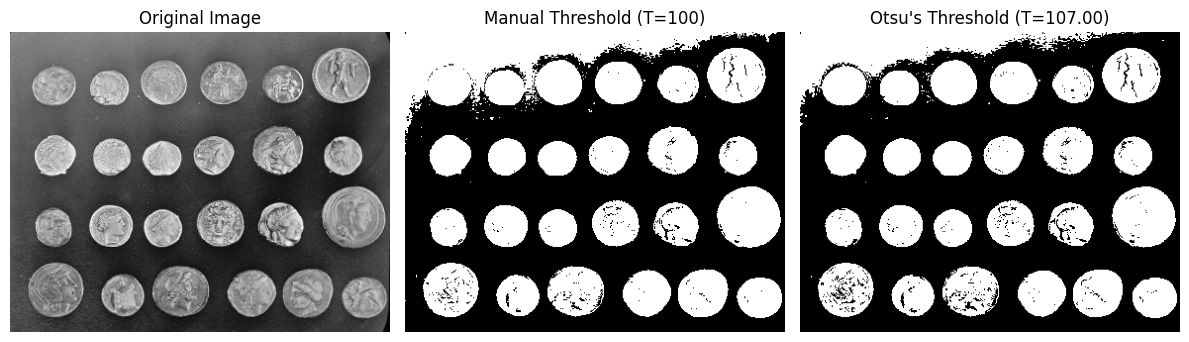

Nilai threshold Otsu yang ditemukan: 107


In [ ]:
import matplotlib.pyplot as plt
from skimage import data, filters, img_as_ubyte
from skimage.color import rgb2gray

# 1. Membuat citra (contoh: coins)
image_coins = data.coins() # citra sudah grayscale

# 2. Thresholding Global (manual)
# Menentukan nilai ambang manual
thresh_manual = 100
binary_manual = image_coins > thresh_manual

# 3. Thresholding Otsu
thresh_otsu = filters.threshold_otsu(image_coins)
binary_otsu = image_coins > thresh_otsu

# 4. Visualisasi Hasil
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
ax = axes.ravel()

ax[0].imshow(image_coins, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(binary_manual, cmap=plt.cm.gray)
ax[1].set_title(f'Manual Threshold (T={thresh_manual})')
ax[1].axis('off')

ax[2].imshow(binary_otsu, cmap=plt.cm.gray)
ax[2].set_title(f'Otsu\'s Threshold (T={thresh_otsu:.2f})')
ax[2].axis('off')

plt.tight_layout()
plt.show()

# Menampilkan nilai threshold Otsu
print(f"Nilai threshold Otsu yang ditemukan: {thresh_otsu}")

### Praktikum 2. Segmentasi Menggunakan Region Growing (Contoh Sederhana)

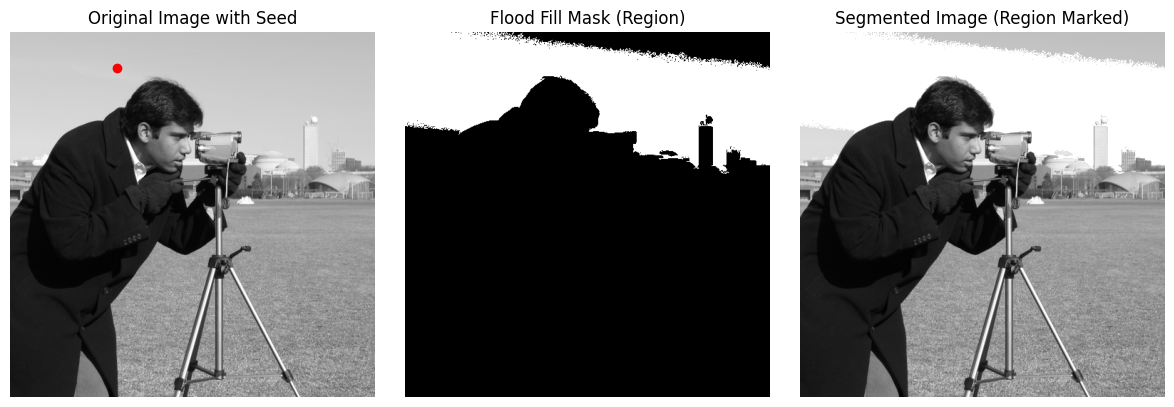

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, segmentation, color


# 1. Memuat citra (contoh: camera)
image_camera = data.camera()

# 2. Tentukan titik 'seed' (benih)
# Misal, kita pilih titik di area langit (misal, koordinat y=50, x=150)
seed_point = (50, 150)

# 3. Terapkan algoritma flood fill (mirip region growing)
# 'tolerance' menentukan seberapa besar perbedaan intensitas yang diizinkan
flood_mask = segmentation.flood(image_camera, seed_point, tolerance=10)

# 4. Buat citra tersegmentasi (tandai region yang 'tumbuh')
segmented_image = np.copy(image_camera)
segmented_image[flood_mask] = 255 # Tandai region dengan warna putih

# 5. Visualisasi Hasil
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
ax = axes.ravel()

ax[0].imshow(image_camera, cmap=plt.cm.gray)
ax[0].plot(seed_point[1], seed_point[0], 'ro') # Tandai seed point
ax[0].set_title('Original Image with Seed')
ax[0].axis('off')

ax[1].imshow(flood_mask, cmap=plt.cm.gray)
ax[1].set_title('Flood Fill Mask (Region)')
ax[1].axis('off')

ax[2].imshow(segmented_image, cmap=plt.cm.gray)
ax[2].set_title('Segmented Image (Region Marked)')
ax[2].axis('off')

plt.tight_layout()
plt.show()

### Praktikum 3. Segmentasi Citra Berwarna Menggunakan K-Means Clustering

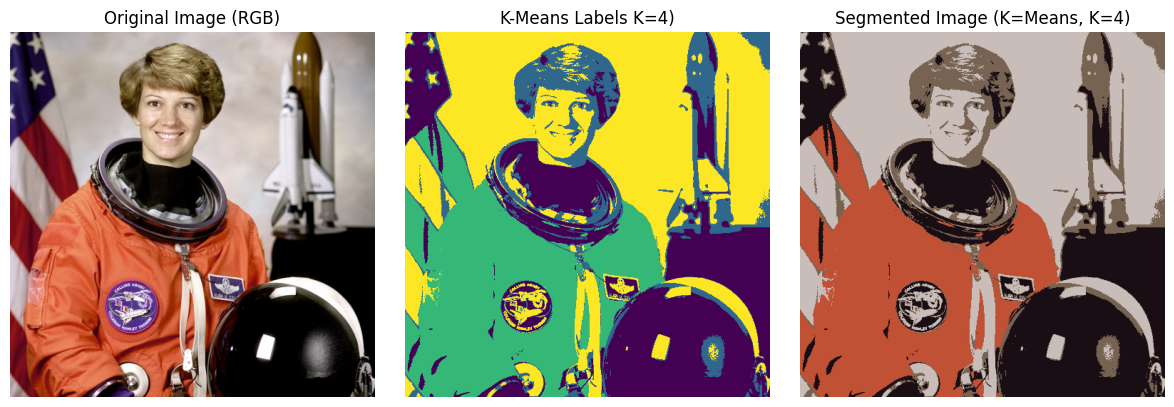

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io
from sklearn.cluster import KMeans
from skimage.color import rgb2lab, lab2rgb
import warnings

# 1. Memuat citra berwarna (contoh: astronaut)
image_astro = data.astronaut()
# Konversi ke float untuk perhitungan
image_astro_float = image_astro.astype(float) / 255.0

# 2. Reshape citra menjadi array piksel [jumlah_piksel, jumlah_fitur]
# Fitur bisa RGB atau Lab. Ruang warna Lab seringkali lebih baik untuk persepsi warna.

# Konversi ke Lab
image_lab = rgb2lab(image_astro_float)
rows, cols, dims = image_lab.shape
pixel_features = image_lab.reshape(rows * cols, dims)

# 3. Terapkan K-Means Clustering
# Tentukan jumlah klaster (segmen) yang diinginkan
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10) # n_init='auto' jika versi sklearn baru

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pixel_labels = kmeans.fit_predict(pixel_features)

# 4. Reshape label kembali ke bentuk citra
segmented_labels = pixel_labels.reshape(rows, cols)

# 5. Buat citra ttersegmentasi (warnai setiap segmen dengan warna rata-rata klaster)
segmented_image_kmeans = np.zeros_like(image_lab)
centers_lab = kmeans.cluster_centers_
for k in range(n_clusters):
    # Dapatkan piksel yang termasuk klaster k
    cluster_pixels = (pixel_labels == k)
    # Isi piksel tersebut di citra baru dengan warna pusat klaster k
    # Perlu reshape kembali cluster_pixels ke bentuk citra
    mask_k = cluster_pixels.reshape(rows, cols)
    segmented_image_kmeans[mask_k] = centers_lab[k]

# Konversi kembali ke RGB untuk ditampilkan
segmented_image_kmeans_rgb = lab2rgb(segmented_image_kmeans)

# 6. Visualisasi Hasil
fix, axes = plt.subplots(ncols=3, figsize=(12, 4))
ax = axes.ravel()

ax[0].imshow(image_astro)
ax[0].set_title('Original Image (RGB)')
ax[0].axis('off')

# Menampilkan label klaster
ax[1].imshow(segmented_labels, cmap='viridis') # cmap bisa diganti
ax[1].set_title(f'K-Means Labels K={n_clusters})')
ax[1].axis('off')

# Menampilkan citra hasil segmentasi K-Means
ax[2].imshow(segmented_image_kmeans_rgb)
ax[2].set_title(f'Segmented Image (K=Means, K={n_clusters})')
ax[2].axis('off')

plt.tight_layout()
plt.show()

### Praktikum 4. Segmentasi Berbasis Tepi Menggunakan Watershed

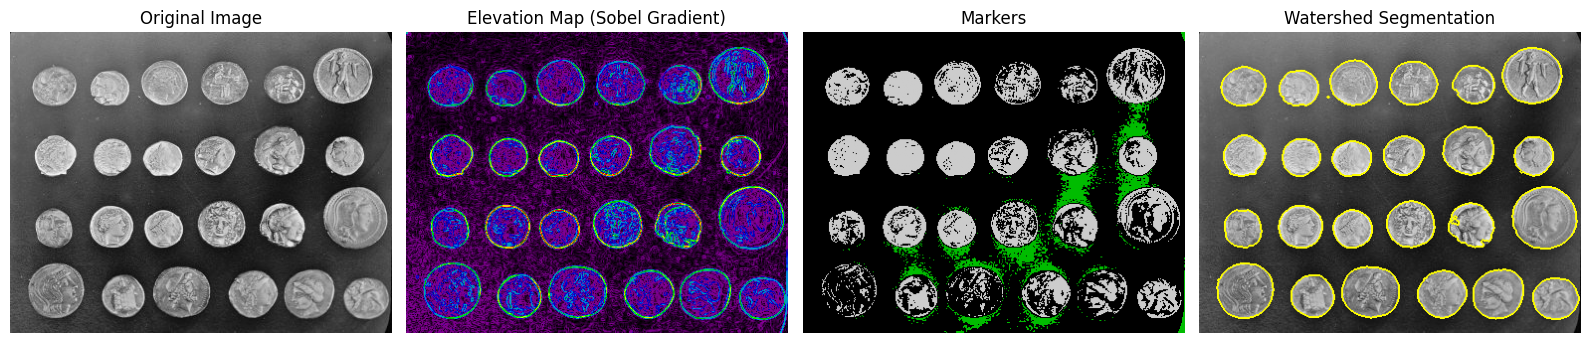

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, filters, segmentation, morphology, measure
from scipy import ndimage as ndi

# 1. Memuat citra (contoh: coins)
image_coins = data.coins()

# 2. Hitung gradien citra (sebagai 'topografi')
elevation_map = filters.sobel(image_coins)

# 3. Tentukan marker (penanda awal untk setiap cekungan/objek)
# Kita bisa menggunakan thresholding untuk mendapatkan marker kasar
markers = np.zeros_like(image_coins)
markers[image_coins < 30] = 1 # Marker untuk latar belakang
markers[image_coins > 150] = 2 # Marker untuk objek (koin)

# Atau gunakan marker dari local maxima (lebih canggih)
# from skimage.feature import peak_local_max
# image_max = ndi.maximum_filter(image_coins, min_distance=20)
# markers = np.zeros(image_coins.shape, dtype=bool)
# markers[tuple(coordinates.T)] = True
# Markers = measure.label(markers)

# 4. Terapkan algoritma watershed
segmentation_watershed = segmentation.watershed(elevation_map, markers)

# Warnai hasil segmentasi untuk visualisasi
segmented_colored = segmentation.mark_boundaries(image_coins, segmentation_watershed)

# 5. Visualisasi Hasil
fig, axes = plt.subplots(ncols=4, figsize=(16, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image_coins, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(elevation_map, cmap=plt.cm.nipy_spectral)
ax[1].set_title('Elevation Map (Sobel Gradient)')
ax[1].axis('off')

ax[2].imshow(markers, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Markers')
ax[2].axis('off')

ax[3].imshow(segmented_colored)
ax[3].set_title('Watershed Segmentation')
ax[3].axis('off')

plt.tight_layout()
plt.show()

### Praktikum 5. Perbandingan Visual Hasil Segmentasi

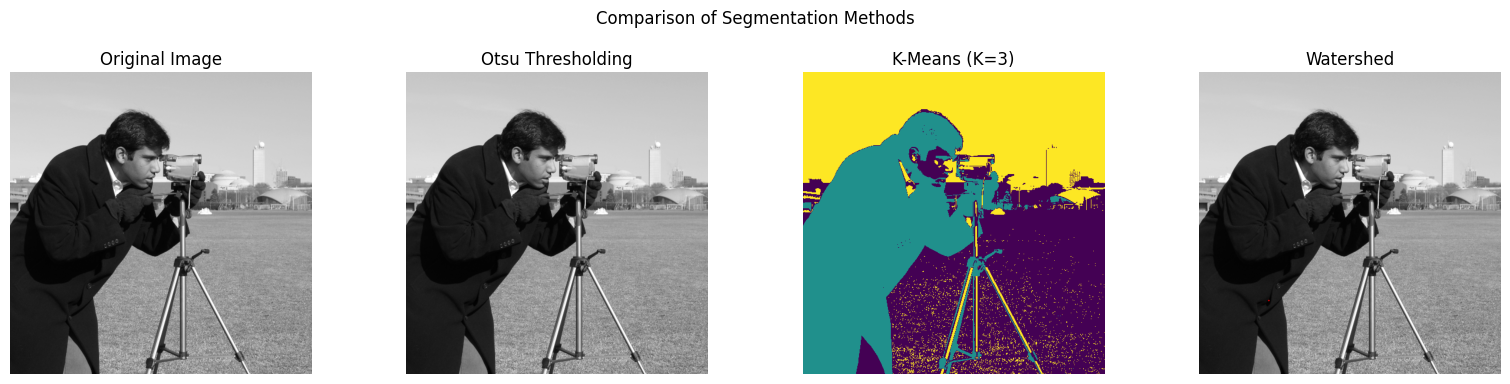

In [ ]:
import matplotlib.pyplot as plt
from skimage import data, filters, segmentation, img_as_float, color
from sklearn.cluster import KMeans
import numpy as np
import warnings
# 1. Pilih satu citra untuk perbandingann (misal: camera)
image = data.camera()
image_float = img_as_float(image)

# 2. Lakukan beberapa metode segmentasi
# a) Otsu Thresholding
thresh_otsu = filters.threshold_otsu(image_float)
binary_otsu = image_float > thresh_otsu

# b) K-Means (misal K=3)
# Reshape untuk K-Means (1 fitur: intensitas)
rows, cols = image.shape
pixel_features = image_float.reshape(rows * cols, 1)
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=0, n_init=10)
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    pixel_labels = kmeans.fit_predict(pixel_features)
segmented_kmeans_labels = pixel_labels.reshape(rows, cols)

# c) Watershed (gunakan marker sederhana dari Otsu)
elevation_map = filters.sobel(image)
markers = np.zeros_like(image)
markers[image < thresh_otsu] = 1
markers[image > thresh_otsu] = 2
segmentation_watershed = segmentation.watershed(elevation_map, markers)

# 3. Visualisasi Perbandingan
fix, axes = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(image, cmap=plt.cm.gray)
ax[1].set_title('Otsu Thresholding')
ax[1].axis('off')

ax[2].imshow(segmented_kmeans_labels, cmap='viridis')
ax[2].set_title(f'K-Means (K={n_clusters})')
ax[2].axis('off')

# Gunakan mark_boundaries untuk Watershed agar lebih jelas
segmented_watershed_colored = segmentation.mark_boundaries(image_float, segmentation_watershed, color=(1, 0, 0))
ax[3].imshow(segmented_watershed_colored)
ax[3].set_title('Watershed')
ax[3].axis('off')

plt.suptitle('Comparison of Segmentation Methods')
plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make space for suptitle
plt.show()

### Penugasan 1 -	Eksperimen Thresholding

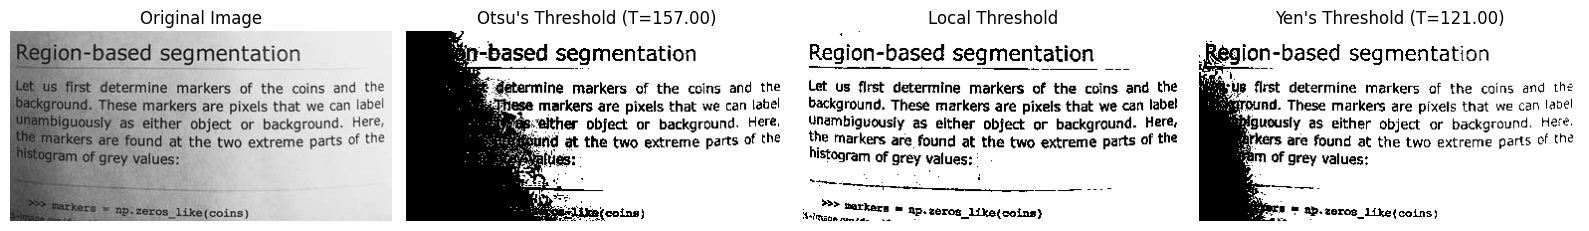

Nilai threshold Otsu pada page: 157
Nilai threshold Yen pada page: 121


In [ ]:
import matplotlib.pyplot as plt
from skimage import data, filters
from skimage.filters import threshold_local, threshold_yen

# 1. Ambil citra baru
image_page = data.page()  # Citra dokumen, grayscale

# 2. Thresholding Otsu
thresh_otsu_page = filters.threshold_otsu(image_page)
binary_otsu_page = image_page > thresh_otsu_page

# 3. Thresholding Local
block_size = 35  # Ukuran blok untuk threshold lokal
local_thresh = threshold_local(image_page, block_size, offset=10)
binary_local_page = image_page > local_thresh

# 4. Thresholding Yen
thresh_yen = filters.threshold_yen(image_page)
binary_yen_page = image_page > thresh_yen

# 5. Visualisasi
fig, axes = plt.subplots(ncols=4, figsize=(16, 4))
ax = axes.ravel()

ax[0].imshow(image_page, cmap=plt.cm.gray)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(binary_otsu_page, cmap=plt.cm.gray)
ax[1].set_title(f"Otsu's Threshold (T={thresh_otsu_page:.2f})")
ax[1].axis('off')

ax[2].imshow(binary_local_page, cmap=plt.cm.gray)
ax[2].set_title('Local Threshold')
ax[2].axis('off')

ax[3].imshow(binary_yen_page, cmap=plt.cm.gray)
ax[3].set_title(f"Yen's Threshold (T={thresh_yen:.2f})")
ax[3].axis('off')

plt.tight_layout()
plt.show()

# Menampilkan nilai threshold
print(f"Nilai threshold Otsu pada page: {thresh_otsu_page}")
print(f"Nilai threshold Yen pada page: {thresh_yen}")


### Penugasan 2 - Menerapkan Metode Segmentasi Berbeda

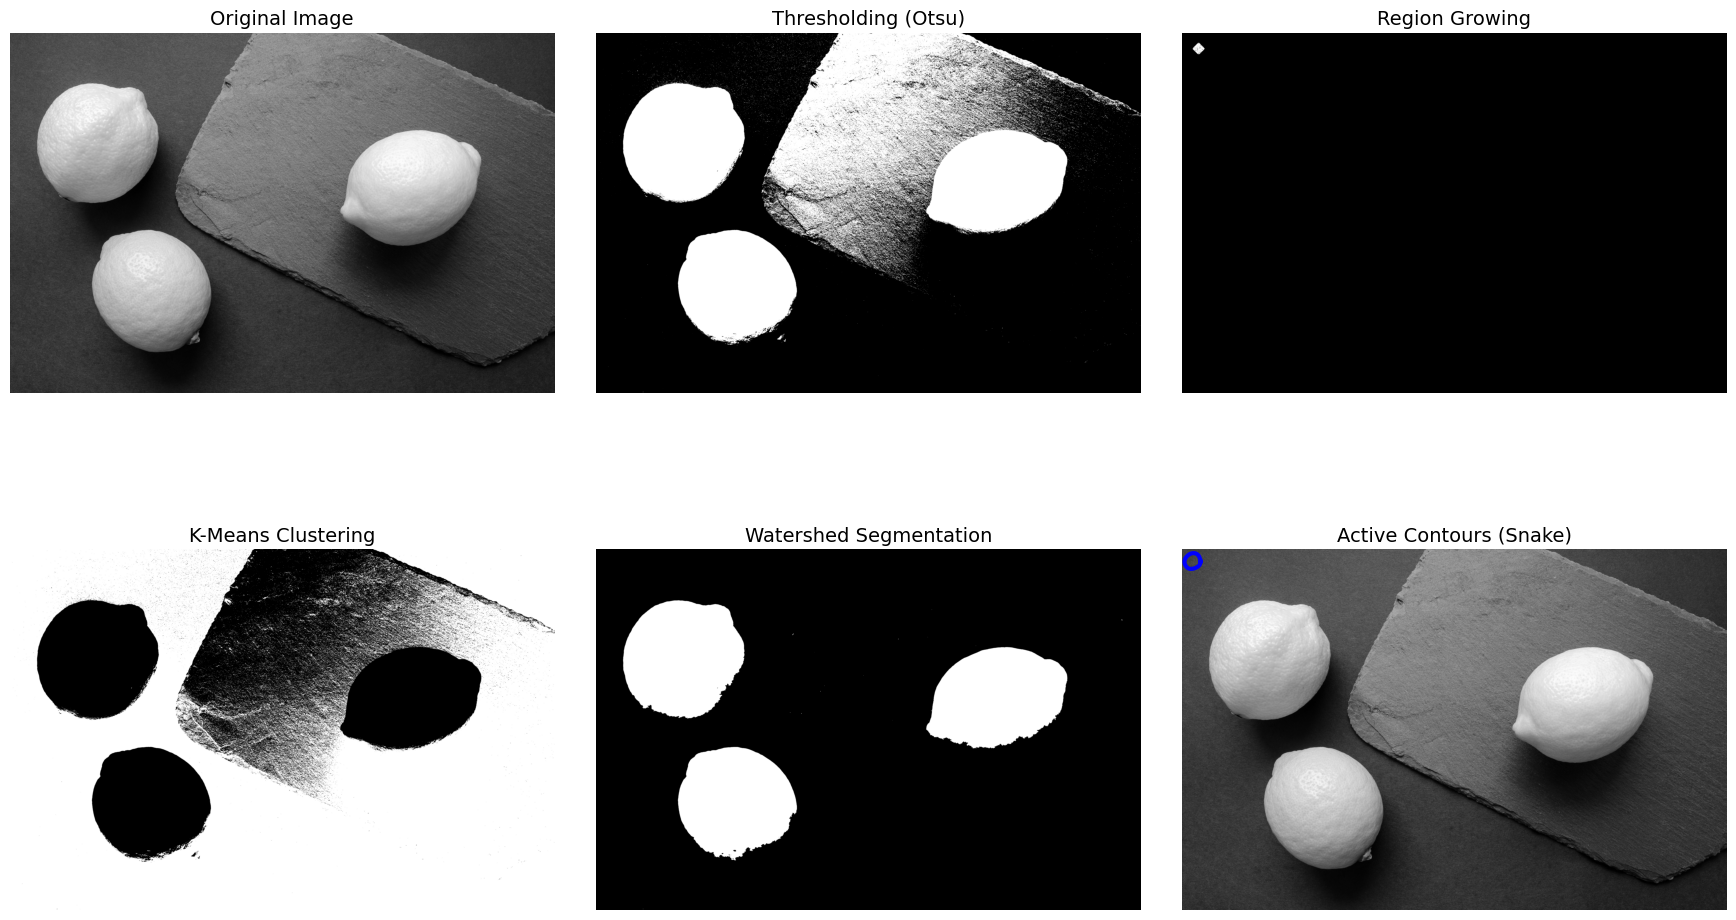

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, color, filters, morphology
from sklearn.cluster import KMeans
from scipy import ndimage as ndi
from skimage.segmentation import watershed, active_contour
from skimage.filters import threshold_otsu

# 1. Load gambar buah
image = io.imread('lemon.jpg')
image = color.rgb2gray(image)  # Ubah ke grayscale

# 2. Thresholding (Otsu)
thresh = threshold_otsu(image)
binary_thresh = image > thresh

# 3. Region Growing (manual seed)
seed_point = (150, 150)  # Atur sesuai gambar
mask = np.zeros_like(image, dtype=bool)
mask[seed_point] = True
grown = morphology.dilation(mask, morphology.disk(5))
for _ in range(50):
    dilated = morphology.binary_dilation(grown)
    grown = np.logical_and(dilated, image > (image[grown].mean() - 0.05))

# 4. K-Means Clustering
pixels = image.reshape(-1, 1)
kmeans = KMeans(n_clusters=2, random_state=42).fit(pixels)
kmeans_labels = kmeans.labels_.reshape(image.shape)

# 5. Watershed
gradient = filters.sobel(image)
markers = np.zeros_like(image, dtype=np.int32)
markers[image < 0.4] = 1
markers[image > 0.8] = 2
labels_ws = watershed(gradient, markers)

# 6. Active Contours (Snake)
s = np.linspace(0, 2*np.pi, 400)
r = 100 + 100*np.sin(s)
c = 100 + 100*np.cos(s)
init = np.array([r, c]).T
snake = active_contour(filters.gaussian(image, 3),
                       init, alpha=0.015, beta=10, gamma=0.001)

# 7. Visualisasi
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original Image', fontsize=14)
axes[0, 0].axis('off')

axes[0, 1].imshow(binary_thresh, cmap='gray')
axes[0, 1].set_title('Thresholding (Otsu)', fontsize=14)
axes[0, 1].axis('off')

axes[0, 2].imshow(grown, cmap='gray')
axes[0, 2].set_title('Region Growing', fontsize=14)
axes[0, 2].axis('off')

axes[1, 0].imshow(kmeans_labels, cmap='gray')
axes[1, 0].set_title('K-Means Clustering', fontsize=14)
axes[1, 0].axis('off')

axes[1, 1].imshow(labels_ws, cmap='gray')
axes[1, 1].set_title('Watershed Segmentation', fontsize=14)
axes[1, 1].axis('off')

axes[1, 2].imshow(image, cmap='gray')
axes[1, 2].plot(snake[:, 1], snake[:, 0], '-b', lw=3)
axes[1, 2].set_title('Active Contours (Snake)', fontsize=14)
axes[1, 2].axis('off')

plt.tight_layout(pad=3.0)
plt.show()
